# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [33]:
df = pd.read_csv('data_full.csv')

In [3]:
rand = np.random.randint(100)

In [4]:
data_num = df
target_tag ='GHGEmissionsIntensity'
target = data_num[target_tag]
sqf = data_num['PropertyGFABuilding(s)']
data_num = data_num.drop(labels = [target_tag,'SiteEnergyUse(kBtu)', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis = 1)

col_name_lib = {}
col_name = data_num.columns
for i,v in enumerate(col_name):
    col_name_lib[f'{i}'] = v

In [5]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 522 entries, BuildingType_Campus to ThirdLargestPropertyUseTypeGFA
dtypes: float64(522)
memory usage: 6.5 MB


## Modèle linéaire

In [6]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [7]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [8]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, random_state = rand, test_size = 0.2)

df_res = xtest
df_res_train = xtrain
#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

In [9]:
def true_pred_plot(y_train,pred_train, y_test, pred_test,figname):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    y_train= np.array(np.exp(y_train)).reshape(-1,1)
    pred_train = np.array(np.exp(pred_train)).reshape(-1,1)
    y_test = np.array(np.exp(y_test)).reshape(-1,1)
    pred_test = np.array(np.exp(pred_test)).reshape(-1,1)
    
    
    
    y_train = (y_train/1000)*sqftrain

    
    pred_train = (pred_train/1000)*sqftrain
    index = np.array(np.where(pred_train == np.inf))
    if index.any() != 0:
        mask = np.ones(len(y_train), dtype = bool)
        mask[index] = False
        pred_train = pred_train[mask].reshape(-1,1)
        y_train = y_train[mask].reshape(-1,1)
    else:
        y_train = y_train.reshape(-1,1)
        pred_train = pred_train.reshape(-1,1)

    
    y_test = (y_test/1000)*sqftest
    pred_test = (pred_test/1000)*sqftest
    index1 = np.array(np.where(pred_test == np.inf))
    if index1.any() != 0:
        mask = np.ones(len(y_test), dtype = bool)
        mask[index1] = False
        pred_test = pred_test[mask].reshape(-1,1)
        y_test = y_test[mask].reshape(-1,1)
    else:
        y_test = y_test.reshape(-1,1)
        pred_test = pred_test.reshape(-1,1)
        
    
    line_reg_train = line_reg.fit(pred_train,y_train)
    r2_train = line_reg_train.score(pred_train,y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(y_train))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    if index.any() != 0:
        ax[0].text(0.7,0.5,'{} infinite value were deleted.'.format(index.shape[1]), transform = ax[0].transAxes)
    ax[0].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(y_train.min(),y_train.max())
    ax[0].set_ylim(pred_train.min(),pred_train.max())
    ax[0].set_title('On train values')


    
    line_reg_test  = line_reg.fit(pred_test,y_test)
    r2_test =  line_reg_test.score(pred_test,y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(y_test))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    if index1.any() != 0:
        ax[1].text(0.7,0.5,'{} infinite value were deleted.'.format(index1.shape[1]),transform = ax[1].transAxes)
    ax[1].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(y_test.min(),y_test.max())
    ax[1].set_ylim(pred_test.min(),pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.savefig(figname, bbox_inches = 'tight')
    plt.clf()

Do you want to launch ? [y/n] y


E:\temp\ipykernel_14988\1687893363.py:7: RuntimeWarning: overflow encountered in exp
  pred_test = np.array(np.exp(pred_test)).reshape(-1,1)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


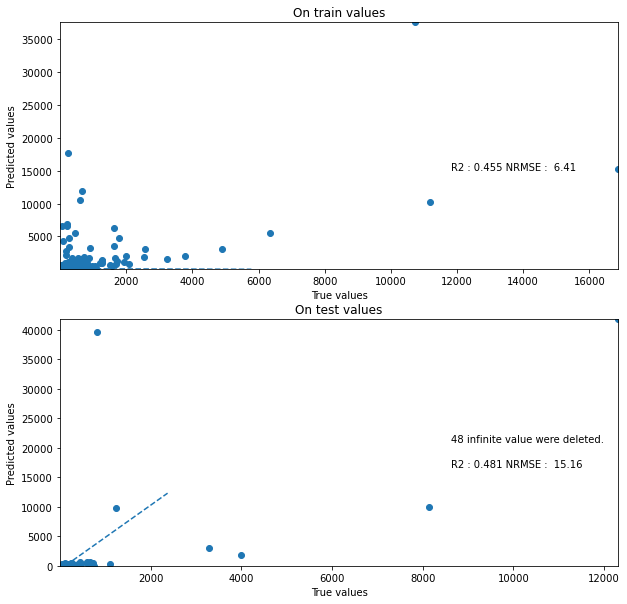

<Figure size 432x288 with 0 Axes>

In [10]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    line_reg_m = linear_model.LinearRegression()

    model_lr = line_reg_m.fit(xtrain,ytrain)


    true_pred_plot(ytrain,  model_lr.predict(xtrain), ytest,  model_lr.predict(xtest),'line_reg_co2.png')

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 10}
GridCV results : 
r2 = 0.014 (+/- 0.079) for {'n_neighbors': 2}
r2 = 0.088 (+/- 0.072) for {'n_neighbors': 3}
r2 = 0.106 (+/- 0.030) for {'n_neighbors': 4}
r2 = 0.119 (+/- 0.033) for {'n_neighbors': 5}
r2 = 0.125 (+/- 0.016) for {'n_neighbors': 6}
r2 = 0.129 (+/- 0.034) for {'n_neighbors': 7}
r2 = 0.124 (+/- 0.015) for {'n_neighbors': 8}
r2 = 0.131 (+/- 0.022) for {'n_neighbors': 9}
r2 = 0.135 (+/- 0.011) for {'n_neighbors': 10}
r2 = 0.132 (+/- 0.020) for {'n_neighbors': 11}
r2 = 0.126 (+/- 0.017) for {'n_neighbors': 12}
r2 = 0.123 (+/- 0.023) for {'n_neighbors': 13}
r2 = 0.115 (+/- 0.028) for {'n_neighbors': 14}
r2 = 0.114 (+/- 0.024) for {'n_neighbors': 15}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


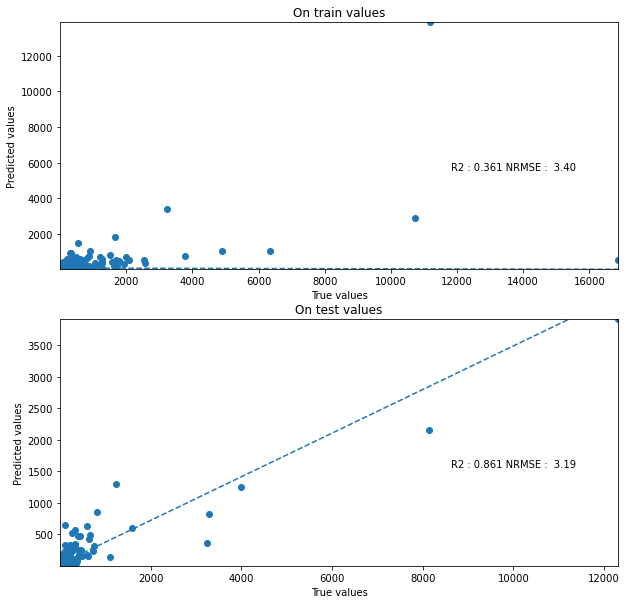

<Figure size 432x288 with 0 Axes>

In [11]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))
    
model_kn = KNeighborsRegressor(n_neighbors = reg.best_params_['n_neighbors']).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_kn.predict(xtrain), ytest, model_kn.predict(xtest),'knn_co2.png')

Do you want to launch ? [y/n] y


Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best params on training set : {'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


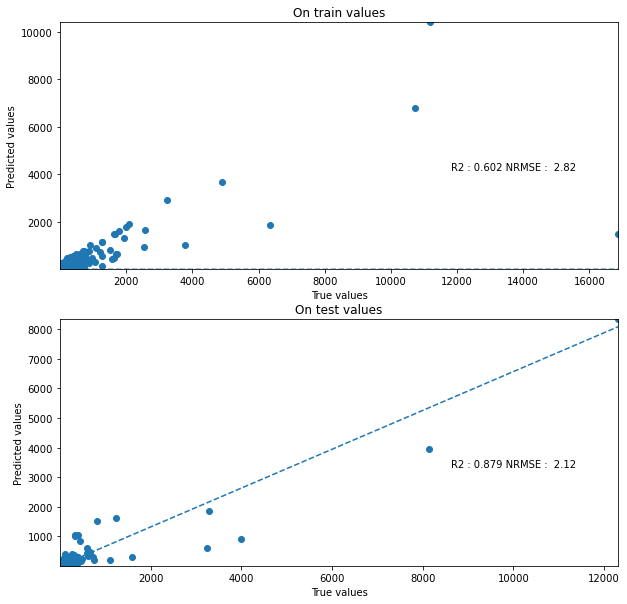

<Figure size 432x288 with 0 Axes>

In [12]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    #let's try with a svr
    C_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'rbf', 'sigmoid', 'poly']
    degrees = [2,3,4]
    gamma_range  = np.logspace(-2, 1, 10)
    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

    score = 'neg_mean_squared_error'

    svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

    svr_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(svr_cv.best_params_))
bkernel = svr_cv.best_params_['kernel']
bgamma = svr_cv.best_params_['gamma']
bdegree = svr_cv.best_params_['degree']
    
svr = svm.SVR(kernel=bkernel, C=1.0, gamma = bgamma, degree = bdegree)
model_svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model_svr.predict(xtrain), ytest, model_svr.predict(xtest),'svr_co2.png')

Fitting 3 folds for each of 240 candidates, totalling 720 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=9.48356e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.5797e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.35339e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.27321e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py

Best params on training set : {'alpha': 100.0, 'degree': 3, 'gamma': 10.0, 'kernel': 'rbf'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


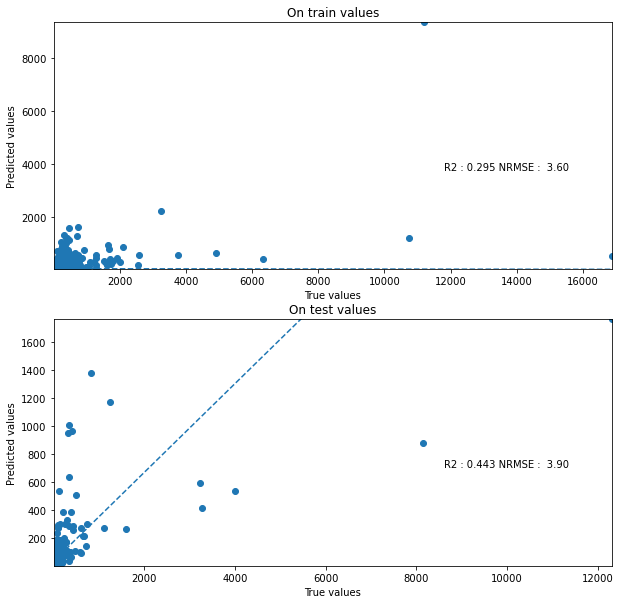

<Figure size 432x288 with 0 Axes>

In [13]:
from sklearn import kernel_ridge
#let's try with a ridge regression

alpha_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['poly', 'rbf']
degrees = [3,4,5]
gamma_range  = np.logspace(-2, 1, 10)


param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
score = 'neg_mean_absolute_percentage_error'

kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

kernel_ridge_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))
    
bkernel = kernel_ridge_cv.best_params_['kernel']
bgamma = kernel_ridge_cv.best_params_['gamma']
bdegree = kernel_ridge_cv.best_params_['degree']
balpha = kernel_ridge_cv.best_params_['alpha']

model = kernel_ridge.KernelRidge(alpha = balpha, kernel = bkernel, degree = bdegree, gamma = bgamma)
model_kr = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model_kr.predict(xtrain), ytest, model_kr.predict(xtest),'krr_co2.png')

## Neural network

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
#test with a single perceptron
model1 = keras.Sequential()
model1.add(keras.Input(shape = xtrain.shape[1]))
model1.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1.summary()

history = model1.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 523       
                                                                 
Total params: 523
Trainable params: 523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 1s 857us/step - loss: 3869741.5000 - root_mean_squared_error: 1.7546
Epoch 2/50
1304/1304 [==============================] - 1s 845us/step - loss: 2925901.7500 - root_mean_squared_error: 1.9780
Epoch 3/50
1304/1304 [==============================] - 1s 835us/step - loss: 3699250.7500 - root_mean_squared_error: 1.9589
Epoch 4/50
1304/1304 [==============================] - 1s 840us/step - loss: 2204425.5000 - root_mean_squared_error: 1.8912
Epoch 5/50
1304/1304 [==============================] - 1s 848us/step - loss: 3380888.

11/11 [==============================] - 0s 800us/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


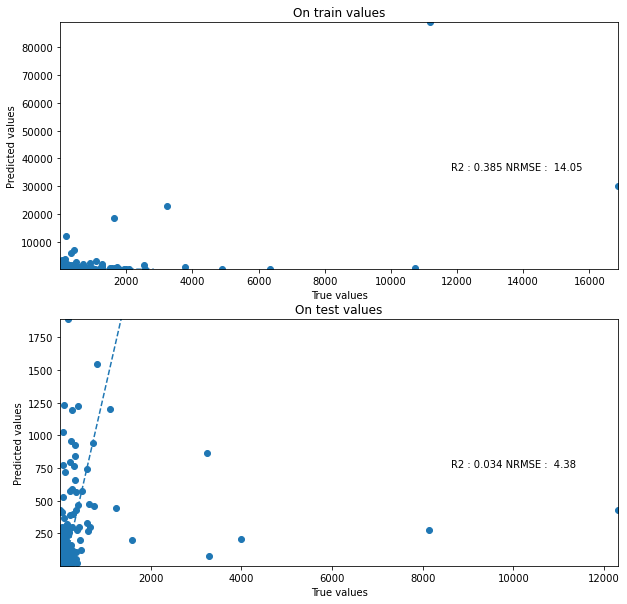

<Figure size 432x288 with 0 Axes>

In [16]:
true_pred_plot(ytrain, model1.predict(xtrain), ytest, model1.predict(xtest),'perc_co2.png')

In [17]:
model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 522)               273006    
                                                                 
 layer2 (Dense)              (None, 287)               150101    
                                                                 
 layer3 (Dense)              (None, 1)                 288       
                                                                 
Total params: 423,395
Trainable params: 423,395
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 3s 2ms/step - loss: 2851013.0000 - root_mean_squared_error: 1.8626
Epoch 2/50
1304/1304 [==============================] - 2s 2ms/step - loss: 23095122.0000 - root_mean_squared_error: 2.6013
Epoch 3/50
1304/1304 [==============================] - 2s 2ms/st

In [18]:
true_pred_plot(ytrain, model2.predict(xtrain), ytest, model2.predict(xtest))

11/11 [==============================] - 0s 2ms/step


TypeError: true_pred_plot() missing 1 required positional argument: 'figname'

In [19]:
#now with a multi layer network

model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2b"),
        layers.Dense(82, activation="relu", name="layer3"),
        layers.Dense(20, activation="relu", name="layer4"),
        layers.Dense(4, activation = "relu", name = "layer5"),
        layers.Dense(1, activation = 'relu', name="layer6"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 522)               273006    
                                                                 
 layer2b (Dense)             (None, 287)               150101    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer5 (Dense)              (None, 4)                 84        
                                                                 
 layer6 (Dense)              (None, 1)                 5         
                                                                 
Total params: 448,472
Trainable params: 448,472
Non-tr

11/11 [==============================] - 0s 2ms/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


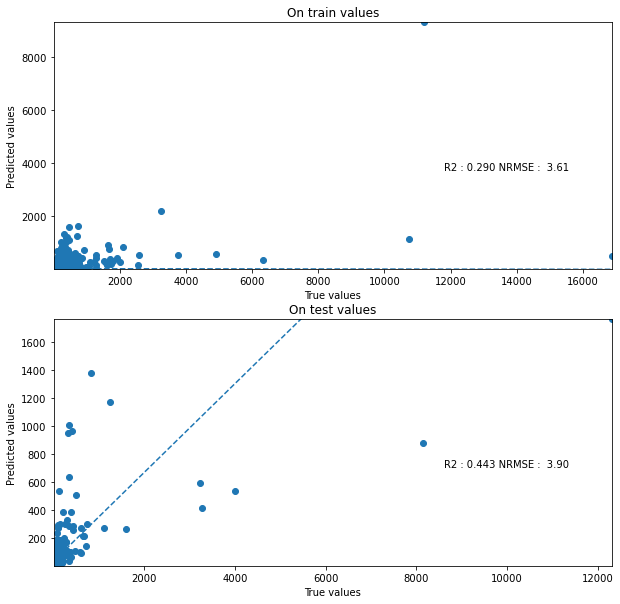

<Figure size 432x288 with 0 Axes>

In [20]:
true_pred_plot(ytrain, model3.predict(xtrain), ytest, model3.predict(xtest),'model3_co2.png')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...................................n_estimators=750; total time=  10.2s
[CV] END ...................................n_estimators=750; total time=  10.0s
[CV] END ...................................n_estimators=750; total time=  13.3s
[CV] END ...................................n_estimators=800; total time=  15.2s
[CV] END ...................................n_estimators=800; total time=  15.1s
[CV] END ...................................n_estimators=800; total time=  15.6s
[CV] END ...................................n_estimators=850; total time=  16.3s
[CV] END ...................................n_estimators=850; total time=  16.1s
[CV] END ...................................n_estimators=850; total time=  16.6s
[CV] END ...................................n_estimators=900; total time=  17.2s
[CV] END ...................................n_estimators=900; total time=  17.1s
[CV] END ...................................n_es

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   25.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

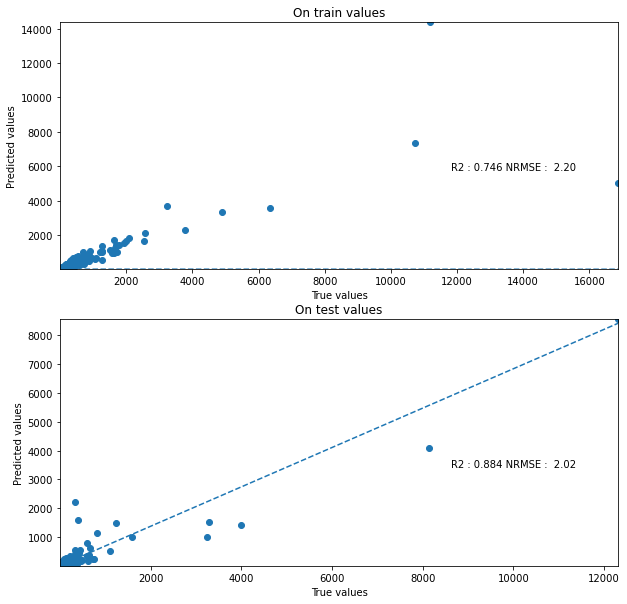

<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.ensemble import RandomForestRegressor

n_grid = {'n_estimators' : list(np.arange(750,1250,50))}
score = 'r2'

rfr_grid = GridSearchCV(RandomForestRegressor(), n_grid, cv =3, scoring = score, verbose = 2)

rfr_grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(rfr_grid.best_params_))

    
model_rfr = RandomForestRegressor(n_estimators=rfr_grid.best_params_['n_estimators'], verbose = 1).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_rfr.predict(xtrain), ytest, model_rfr.predict(xtest), 'rfr_co2.png')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...................................n_estimators=250; total time=   1.5s
[CV] END ...................................n_estimators=250; total time=   1.7s
[CV] END ...................................n_estimators=250; total time=   1.5s
[CV] END ...................................n_estimators=300; total time=   1.9s
[CV] END ...................................n_estimators=300; total time=   1.9s
[CV] END ...................................n_estimators=300; total time=   1.9s
[CV] END ...................................n_estimators=350; total time=   2.2s
[CV] END ...................................n_estimators=350; total time=   2.3s
[CV] END ...................................n_estimators=350; total time=   2.2s
[CV] END ...................................n_estimators=400; total time=   2.5s
[CV] END ...................................n_estimators=400; total time=   2.5s
[CV] END ...................................n_es

E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


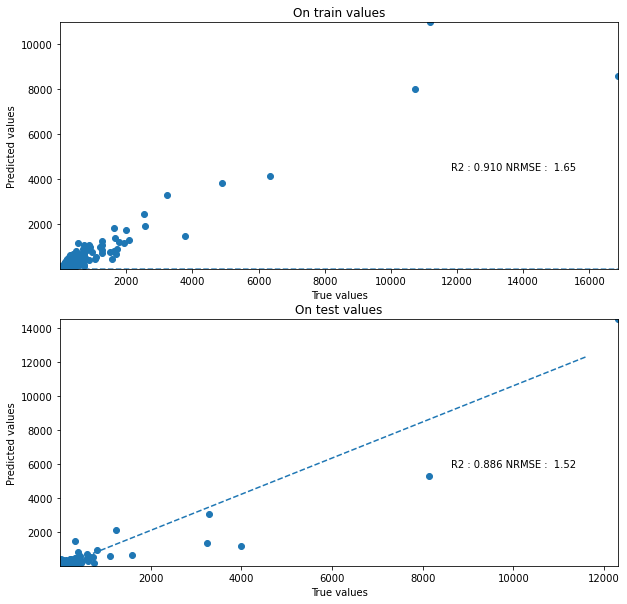

<Figure size 432x288 with 0 Axes>

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

n_grid = {'n_estimators' : list(np.arange(250,750,50))}
score = 'r2'

xgb_grid = GridSearchCV( GradientBoostingRegressor(), n_grid, cv =3, scoring = score, verbose = 2)

xgb_grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(xgb_grid.best_params_))

    
model_xgb =  GradientBoostingRegressor(n_estimators=xgb_grid.best_params_['n_estimators'], verbose = 1).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_xgb.predict(xtrain), ytest, model_xgb.predict(xtest),'xgb_co2.png')

In [23]:
def r2(pred,y):
    pred = np.array(np.exp(pred)).reshape(-1,1)
    y = np.array(np.exp(y)).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    line_reg_test  = line_reg.fit(pred,y)
    r2_value =  line_reg_test.score(pred,y)
    return r2_value

def rmse(pred,y):
    pred = np.array(np.exp(pred)).reshape(-1,1)
    y = np.array(np.exp(y)).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    rmse_value = np.sqrt(metrics.mean_squared_error(y,pred))
    return rmse_value

def nrmse(pred,y):
    pred = np.array(np.exp(pred)).reshape(-1,1)
    y = np.array(np.exp(y)).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    nrmse_value = (np.sqrt(metrics.mean_squared_error(y,pred))/np.mean(y))
    return nrmse_value
                   
def mae(pred,y):
    pred = np.array(np.exp(pred)).reshape(-1,1)
    y = np.array(np.exp(y)).reshape(-1,1)
    
    pred = (pred/1000)*sqftest
    y = (y/1000)*sqftest
    
    mae_value = metrics.mean_absolute_error(y,pred)
    return mae_value

11/11 [==============================] - 0s 2ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.1s finished


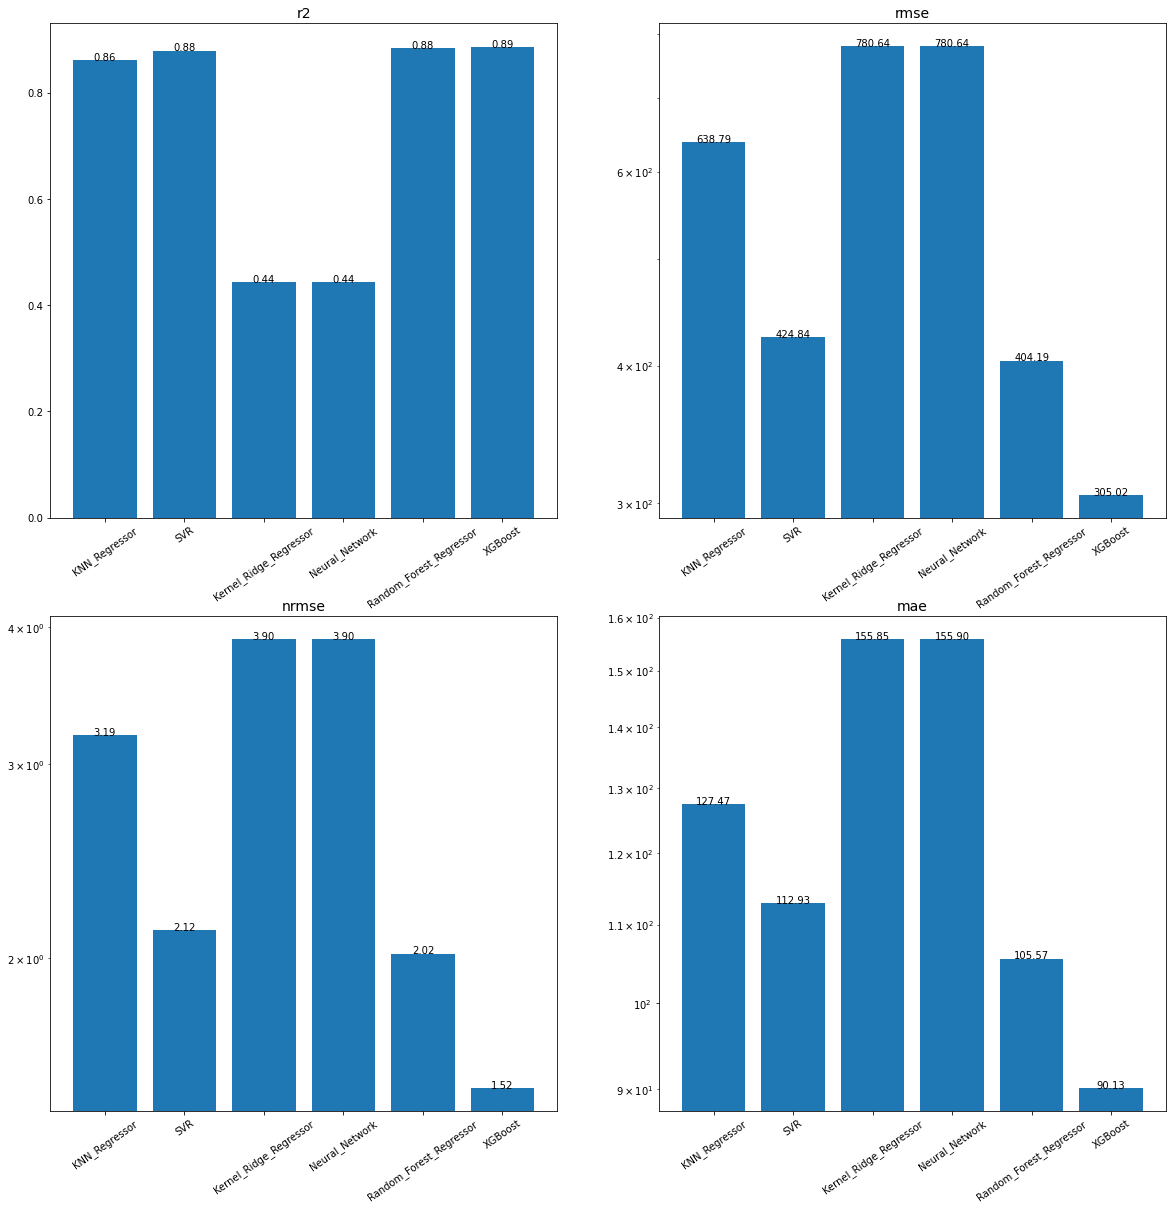

In [24]:
metrics_all = {}

models = [model_kn,svr,model_kr,model3,model_rfr,model_xgb]
r2l=[]
rmsel=[]
nrmsel=[]
mael=[]

for i in models:
    r2l.append(r2(i.predict(xtest),ytest))
    rmsel.append(rmse(i.predict(xtest), ytest))
    nrmsel.append(nrmse(i.predict(xtest), ytest))
    mael.append(mae(i.predict(xtest), ytest))
    
metrics_all['r2'] = r2l
metrics_all['rmse'] = rmsel
metrics_all['nrmse'] = nrmsel
metrics_all['mae'] = mael

model_names = ['KNN_Regressor', 'SVR', 'Kernel_Ridge_Regressor','Neural_Network', 'Random_Forest_Regressor', 'XGBoost']
df_metrics = pd.DataFrame(metrics_all, index = model_names)

fig = plt.figure(figsize=(20, 20))
for i in range(df_metrics.shape[1]):
    ax = fig.add_subplot(2,2, (i+1))
    b = ax.bar(x=df_metrics.index,height = df_metrics.iloc[:, i])
    for y,v in enumerate(df_metrics.iloc[:, i]):
        ax.text(y,v, '%.2f'%v, ha = 'center')
    ax.set_title(df_metrics.columns[i], fontsize=14)
    ax.tick_params(axis='x', labelrotation = 35)
    if i != 0:
        ax.set_yscale('log')
plt.savefig('metrics_co2.png', bbox_inches = 'tight')

65
ThirdLargestPropertyUseTypeGFA                       0.139900
PropertyGFABuilding(s)                               0.084064
YearBuilt                                            0.074892
SecondLargestPropertyUseTypeGFA                      0.062612
Latitude                                             0.056869
LargestPropertyUseType_Office                        0.054048
Longitude                                            0.052850
LargestPropertyUseType_Supermarket/Grocery Store     0.032924
ZipCode                                              0.032479
LargestPropertyUseType_Non-Refrigerated Warehouse    0.030327
Name: Feature_Importance, dtype: float64


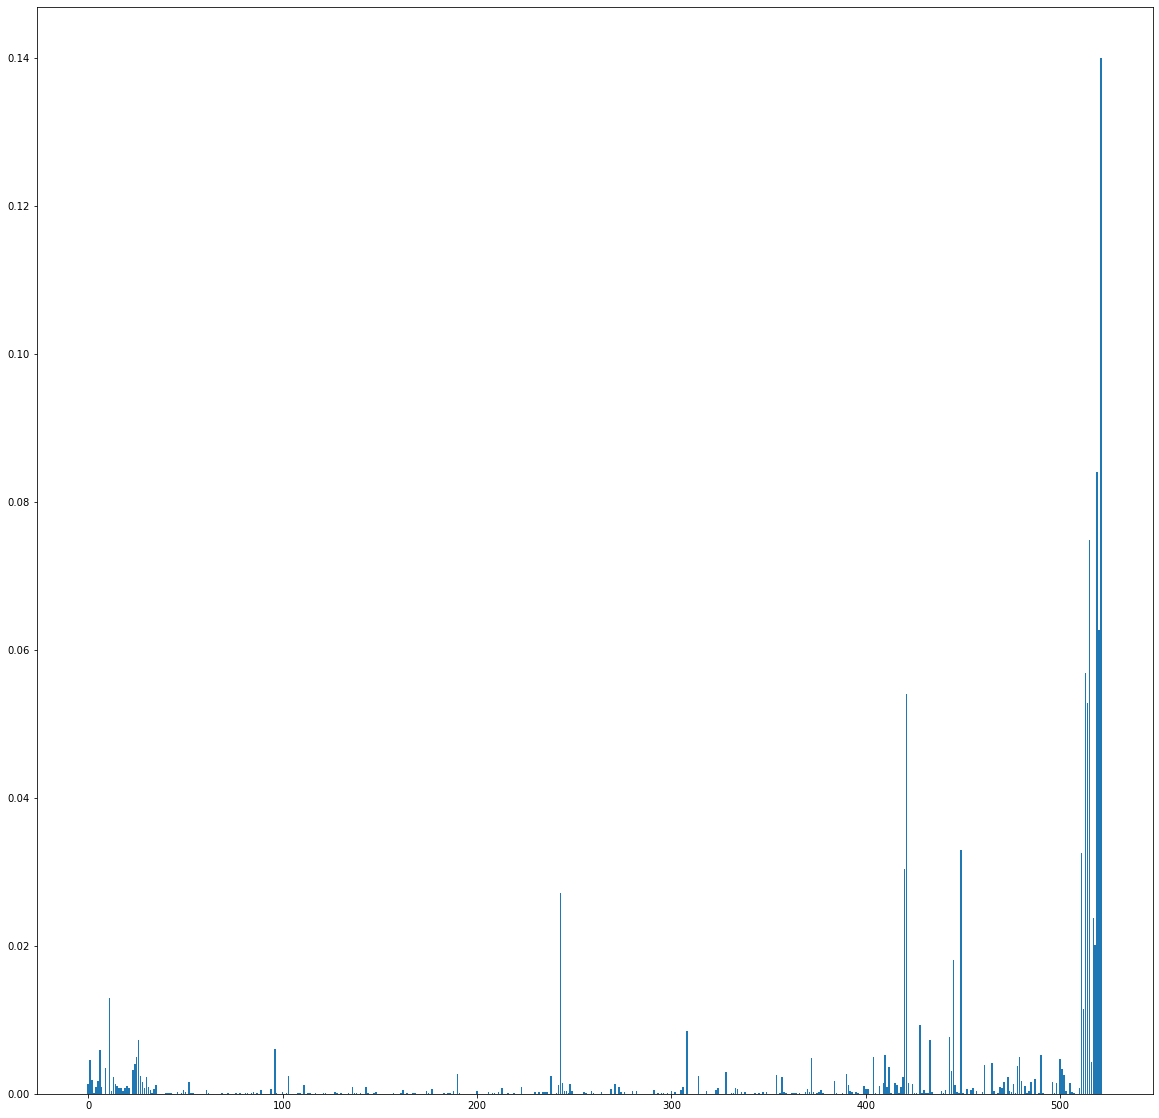

<Figure size 432x288 with 0 Axes>

In [25]:
importance = model_rfr.feature_importances_
nul_col = []
for i,v in enumerate(importance):
    if v == 0:
        nul_col.append(i)
nul_col_name = []
for i in nul_col:
    nul_col_name.append(col_name_lib[str(i)])
print(len(nul_col_name))

df_fi = {}
for i,v in enumerate(importance):
    x = col_name_lib[str(i)]
    df_fi[f'{x}'] = v

df_fi = pd.DataFrame(df_fi, index = ['Feature_Importance']).T
print(df_fi['Feature_Importance'].nlargest(10))


# plot feature importance
fig, ax = plt.subplots(figsize = (20,20))
ax.bar([x for x in range(len(importance))], importance)
plt.show()
plt.savefig('feat_imp_co2.png', bbox_inches = 'tight')

In [26]:
df_year={}
df_tar = pd.DataFrame(ytest)
df_res = df_res.join(df_tar)
for i in df_res['YearBuilt'].unique():
    df_year[f'{i}'] = df_res[df_res['YearBuilt'] == i]
len(df_year)



99

In [27]:
def feature_error(df_lib,model,met,newcol=None):
    results = []
    for i in df_lib:
        x = df_lib[str(i)]
        if newcol:
            x = x.drop(axis = 1, labels = newcol)
        y = x['GHGEmissionsIntensity']
        x = x.drop(axis = 1, labels = 'GHGEmissionsIntensity')
        sqf = x['PropertyGFABuilding(s)']
        x = sscaler_fit.transform(x)
        
   
        pred = model.predict(x)
        
        y = np.array(np.exp(y)).reshape(-1,1)
        pred = np.array(np.exp(pred)).reshape(-1,1)
        index = np.array(np.where(pred == np.inf))
        if index.any() != 0:
            mask = np.ones(len(y), dtype = bool)
            mask[index] = False
            pred = pred[mask].reshape(-1,1)
            y = y[mask].reshape(-1,1)
        else:
            y = y.reshape(-1,1)
            pred = pred.reshape(-1,1)
        
        sqf = np.array(sqf).reshape(-1,1)
        y = y*sqf
        pred = pred*sqf
        
        if met == 'r2':
            line_reg_fit  = line_reg.fit(pred,y)
            results.append(line_reg_fit.score(pred,y))
        if met == 'nrmse':
            results.append(np.sqrt(metrics.mean_squared_error(y,pred))/np.mean(y))
        if met =='mae':
            results.append(np.sqrt(metrics.mean_absolute_error(y,pred)))
    return results
    

1953.0    999.638144
1997.0    977.152394
1994.0    906.359959
1964.0    800.718978
1945.0    722.460516
2012.0    705.499304
1999.0    559.618702
1931.0    473.827502
1978.0    473.371803
1912.0    424.582606
Name: NRMSE, dtype: float64


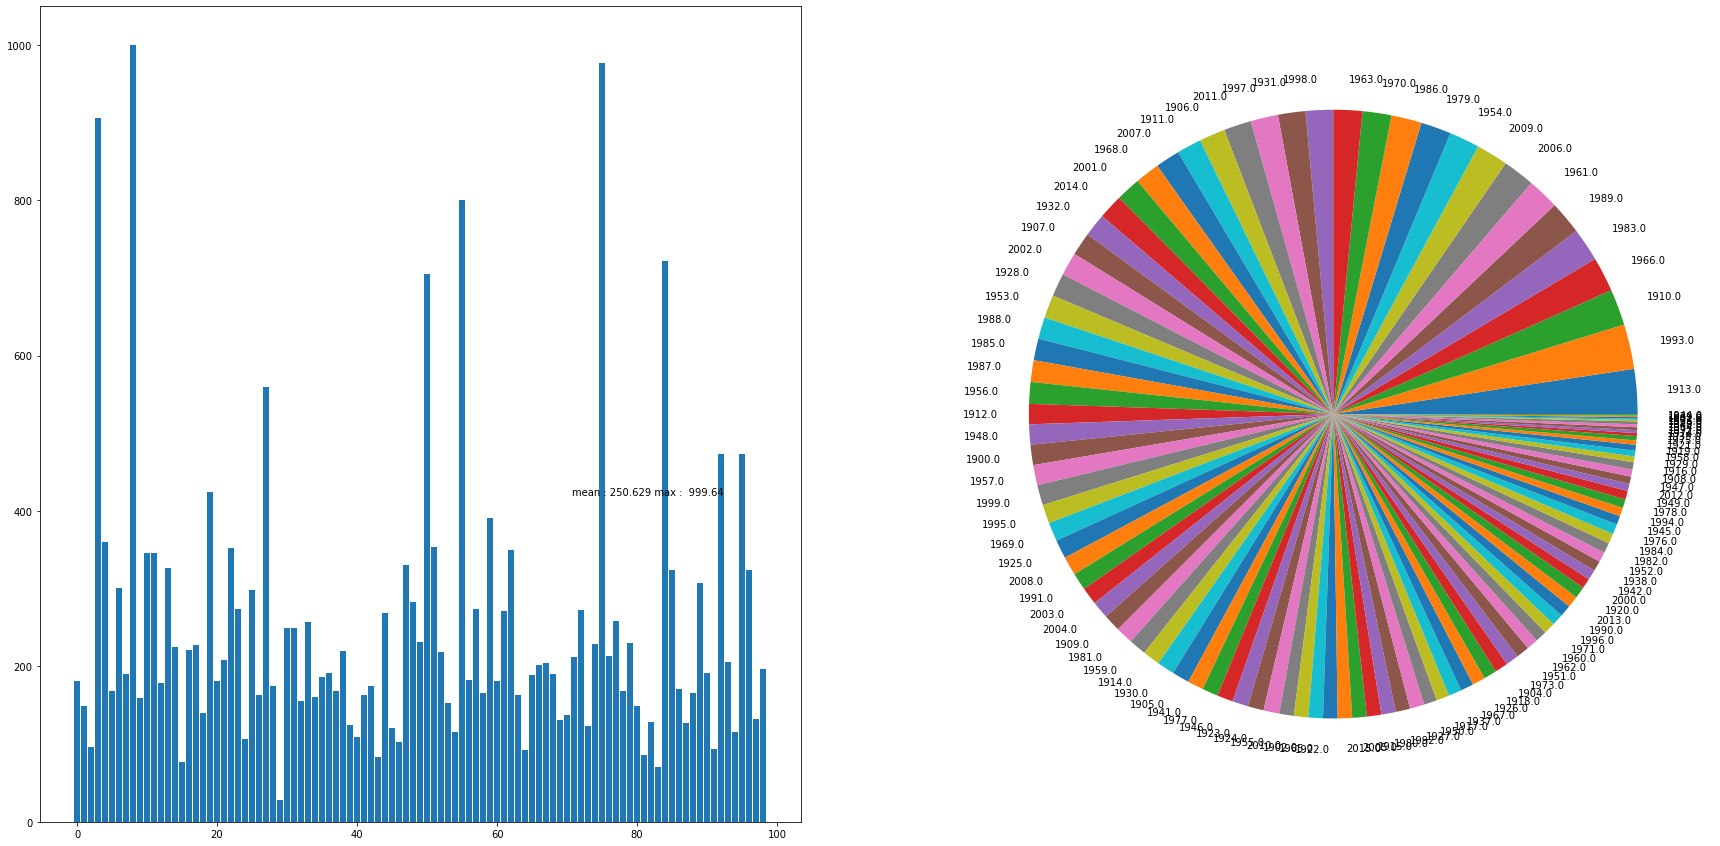

In [29]:
results = feature_error(df_year,model_xgb,'mae')

results_year = {}
for i,v in zip(df_year,results):
    results_year[f'{i}'] = v
    
results_year = pd.DataFrame(results_year, index = ['NRMSE']).T
print(results_year['NRMSE'].nlargest(10))

fig, ax = plt.subplots(1,2,figsize = (30,15))
ax[0].bar([x for x in range(len(results_year.index))],results_year['NRMSE'])
ax[0].text(0.7,0.4,'mean : {:.3f} max : {: .2f}'.format(results_year['NRMSE'].mean(), results_year['NRMSE'].max()), transform = ax[0].transAxes)
ax[1].pie(df_res_train['YearBuilt'].value_counts(), labels = df_res_train['YearBuilt'].unique())
plt.savefig('YearBuilt_co2.png', bbox_inches = 'tight')
plt.show()

4    20546.524909
5    12509.351756
0     1154.825004
2     1032.939498
6     1019.238547
3      761.733562
9      528.739449
7      404.578128
8      344.682247
1      296.235990
Name: NRMSE, dtype: float64


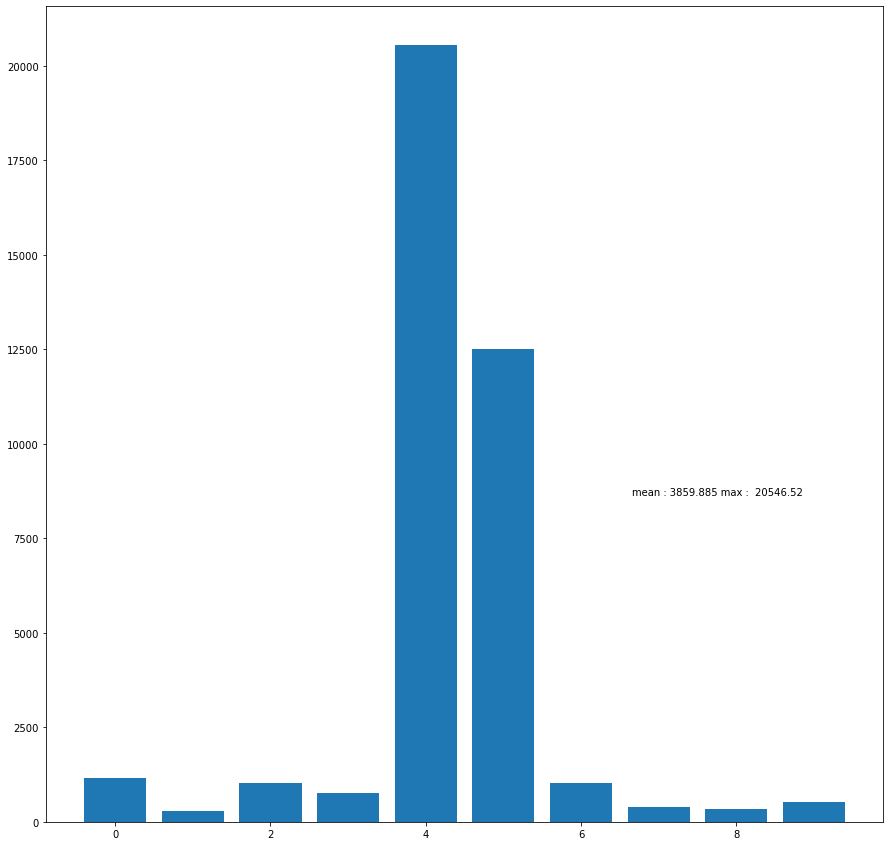

In [30]:
df_gfa = df
df_gfa['GFAdistribution'] = pd.qcut(df_gfa['ThirdLargestPropertyUseTypeGFA'],10, duplicates = 'drop')
target = df_gfa[target_tag]
sqf = df_gfa['PropertyGFABuilding(s)']
gfa_dis = df_gfa['GFAdistribution']
df_gfa = df_gfa.drop(labels = [target_tag,'GFAdistribution', 'TotalGHGEmissions', 'ENERGYSTARScore','SiteEUI(kBtu/sf)','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity'], axis = 1)

xtrain, xtest, ytrain, ytest, sqftrain, sqftest, distrain, distest = train_test_split(df_gfa, target, sqf, gfa_dis, test_size = 0.2, random_state = rand)
df_gfa_res = xtest
df_gfa_res = df_gfa_res.join(pd.DataFrame(distest))
df_gfa_res = df_gfa_res.join(pd.DataFrame(ytest))


df_gfa_lib = {}
for i,v in enumerate(df_gfa_res['GFAdistribution'].unique()):
    df_gfa_lib[f'{i}'] = df_gfa_res[df_gfa_res['GFAdistribution'] == v]

results = feature_error(df_gfa_lib,model_xgb,'mae',newcol = 'GFAdistribution')

results_gfa = {}
for i,v in zip(df_gfa_lib,results):
    results_gfa[f'{str(i)}'] = v
    
results_gfa = pd.DataFrame(results_gfa, index = ['NRMSE']).T
print(results_gfa['NRMSE'].nlargest(10))

fig, ax = plt.subplots(figsize = (15,15))
ax.bar([x for x in range(len(results_gfa.index))],results_gfa['NRMSE'])
ax.text(0.7,0.4,'mean : {:.3f} max : {: .2f}'.format(results_gfa['NRMSE'].mean(), results_gfa['NRMSE'].max()), transform = ax.transAxes)
plt.savefig('ThirdGFAanalysis_co2.png', bbox_inches = 'tight')
plt.show()

9    25656.483002
0     1068.185743
6      534.402418
5      504.466394
7      449.274972
1      366.353803
8      364.023845
3      322.319223
4      224.028755
2      195.708900
Name: NRMSE, dtype: float64


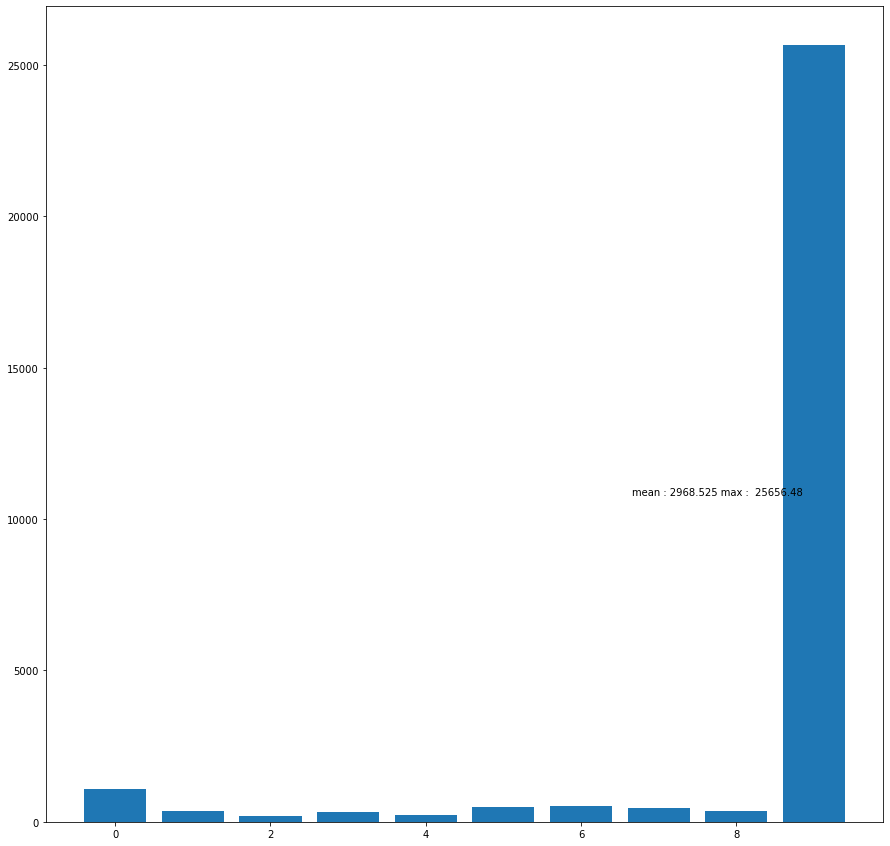

In [31]:
df_tar = df
df_tar['Ydistribution'] = pd.qcut(df_tar[target_tag],10, duplicates = 'drop')
target = df_tar[target_tag]
sqf = df_tar['PropertyGFABuilding(s)']
dis = df_tar['Ydistribution']
df_tar = df_tar.drop(labels = [target_tag,'Ydistribution','TotalGHGEmissions', 'ENERGYSTARScore','SiteEUI(kBtu/sf)','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity'], axis = 1)

xtrain, xtest, ytrain, ytest, sqftrain, sqftest,distrain,distest = train_test_split(df_gfa, target, sqf,dis, test_size = 0.2, random_state = rand)
df_tar_res = xtest
df_tar_res = df_tar_res.join(pd.DataFrame(dis))
df_tar_res = df_tar_res.join(pd.DataFrame(ytest))


df_tar_lib = {}
for i,v in enumerate(df_tar_res['Ydistribution'].unique()):
    df_tar_lib[f'{i}'] = df_tar_res[df_tar_res['Ydistribution'] == v]

results = feature_error(df_tar_lib,model_xgb,'mae',newcol = 'Ydistribution')

results_tar = {}
for i,v in zip(df_tar_lib,results):
    results_tar[f'{str(i)}'] = v
    
results_tar = pd.DataFrame(results_tar, index = ['NRMSE']).T
print(results_tar['NRMSE'].nlargest(10))

fig, ax = plt.subplots(figsize = (15,15))
ax.bar([x for x in range(len(results_tar.index))],results_tar['NRMSE'])
ax.text(0.7,0.4,'mean : {:.3f} max : {: .2f}'.format(results_tar['NRMSE'].mean(), results_tar['NRMSE'].max()), transform = ax.transAxes)
plt.savefig('TargetAanalysis_co2.png', bbox_inches = 'tight')
plt.show()

## Etude de l'impact de l'Energy Score

In [34]:
data_num = df
target_tag ='GHGEmissionsIntensity'
target = data_num[target_tag]
sqf = data_num['PropertyGFABuilding(s)']
data_num = data_num.drop(labels = [target_tag,'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions'], axis = 1)

col_name_lib = {}
col_name = data_num.columns
for i,v in enumerate(col_name):
    col_name_lib[f'{i}'] = v
    
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, test_size = 0.2)

df_res = xtest
df_res_train = xtrain
#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit2 = sscaler.fit(xtrain)
xtrain = sscaler_fit2.transform(xtrain)
xtest = sscaler_fit2.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

In [ ]:
col_name_lib = {}
col_name = data_num.columns
for i,v in enumerate(col_name):
    col_name_lib[f'{i}'] = v

In [35]:
k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

model_kn2 = KNeighborsRegressor(n_neighbors = reg.best_params_['n_neighbors']).fit(xtrain, ytrain)


#let's try with a svr
C_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
degrees = [2,3,4]
gamma_range  = np.logspace(-2, 1, 10)
param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

score = 'neg_mean_squared_error'

svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

svr_cv.fit(xtrain, ytrain)


bkernel = svr_cv.best_params_['kernel']
bgamma = svr_cv.best_params_['gamma']
bdegree = svr_cv.best_params_['degree']
    
svr = svm.SVR(kernel=bkernel, C=1.0, gamma = bgamma, degree = bdegree)
model_svr2= svr.fit(xtrain,ytrain)

#kernel ridge
alpha_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['poly', 'rbf']
degrees = [3,4,5]
gamma_range  = np.logspace(-2, 1, 10)


param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
score = 'neg_mean_absolute_percentage_error'

kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

kernel_ridge_cv.fit(xtrain, ytrain)

bkernel = kernel_ridge_cv.best_params_['kernel']
bgamma = kernel_ridge_cv.best_params_['gamma']
bdegree = kernel_ridge_cv.best_params_['degree']
balpha = kernel_ridge_cv.best_params_['alpha']

model = kernel_ridge.KernelRidge(alpha = balpha, kernel = bkernel, degree = bdegree, gamma = bgamma)
model_kr2 = model.fit(xtrain, ytrain)

#Neural network
model3_2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2b"),
        layers.Dense(82, activation="relu", name="layer3"),
        layers.Dense(20, activation="relu", name="layer4"),
        layers.Dense(4, activation = "relu", name = "layer5"),
        layers.Dense(1, activation = 'relu', name="layer6"),
    ]
)

model3_2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3_2.summary()

history3 = model3_2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

#random forest
n_grid = {'n_estimators' : list(np.arange(750,1250,50))}
score = 'r2'

rfr_grid = GridSearchCV(RandomForestRegressor(), n_grid, cv =3, scoring = score, verbose = 2)

rfr_grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(rfr_grid.best_params_))

    
model_rfr2 = RandomForestRegressor(n_estimators=rfr_grid.best_params_['n_estimators'], verbose = 1).fit(xtrain, ytrain)

#xgb
n_grid = {'n_estimators' : list(np.arange(250,750,50))}
score = 'r2'

xgb_grid = GridSearchCV( GradientBoostingRegressor(), n_grid, cv =3, scoring = score, verbose = 2)

xgb_grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(xgb_grid.best_params_))

    
model_xgb2 =  GradientBoostingRegressor(n_estimators=xgb_grid.best_params_['n_estimators'], verbose = 1).fit(xtrain, ytrain)




Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Fitting 3 folds for each of 240 candidates, totalling 720 fits
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 523)               274052    
                                                                 
 layer2b (Dense)             (None, 287)               150388    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer5 (Dense)              (None, 4)                 84        
                                                                 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   23.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...................................n_estimators=250; total time=   1.4s
[CV] END ...................................n_estimators=250; total time=   1.3s
[CV] END ...................................n_estimators=250; total time=   1.4s
[CV] END ...................................n_estimators=300; total time=   1.6s
[CV] END ...................................n_estimators=300; total time=   1.6s
[CV] END ...................................n_estimators=300; total time=   1.6s
[CV] END ...................................n_estimators=350; total time=   2.0s
[CV] END ...................................n_estimators=350; total time=   1.9s
[CV] END ...................................n_estimators=350; total time=   2.0s
[CV] END ...................................n_estimators=400; total time=   2.3s
[CV] END ...................................n_estimators=400; total time=   2.2s
[CV] END ...................................n_es

11/11 [==============================] - 0s 2ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished


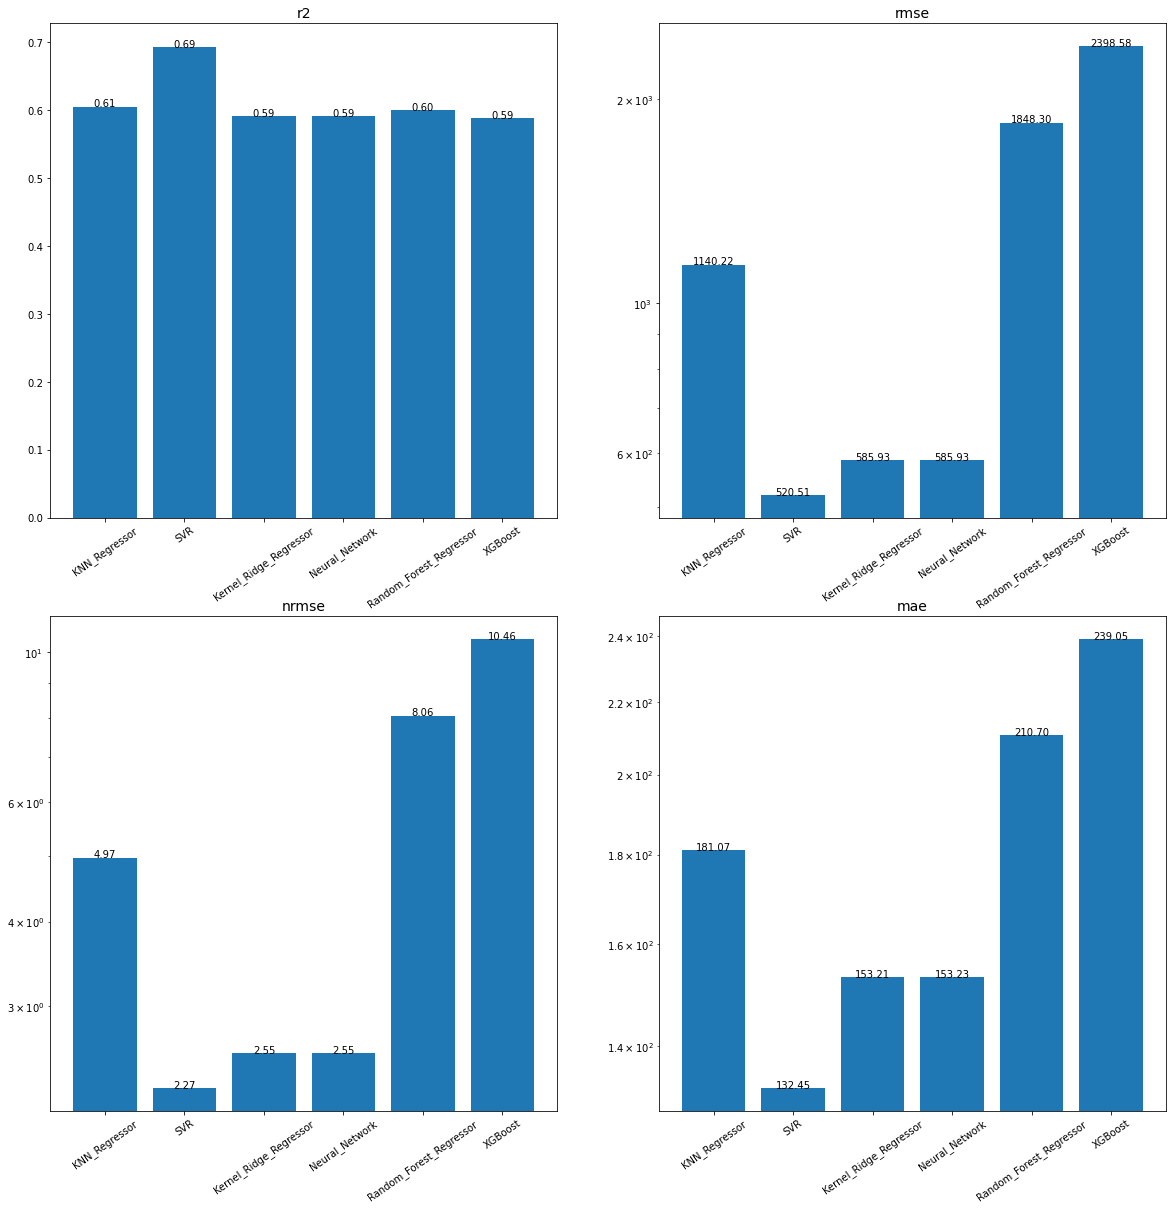

In [36]:
#plot the metrics
metrics_all = {}

models = [model_kn2,model_svr2,model_kr2,model3_2,model_rfr2,model_xgb2]
r2l=[]
rmsel=[]
nrmsel=[]
mael=[]

for i in models:
    r2l.append(r2(i.predict(xtest),ytest))
    rmsel.append(rmse(i.predict(xtest), ytest))
    nrmsel.append(nrmse(i.predict(xtest), ytest))
    mael.append(mae(i.predict(xtest), ytest))
    
metrics_all['r2'] = r2l
metrics_all['rmse'] = rmsel
metrics_all['nrmse'] = nrmsel
metrics_all['mae'] = mael

model_names = ['KNN_Regressor', 'SVR', 'Kernel_Ridge_Regressor','Neural_Network', 'Random_Forest_Regressor', 'XGBoost']
df_metrics = pd.DataFrame(metrics_all, index = model_names)

fig = plt.figure(figsize=(20, 20))
for i in range(df_metrics.shape[1]):
    ax = fig.add_subplot(2,2, (i+1))
    b = ax.bar(x=df_metrics.index,height = df_metrics.iloc[:, i])
    for y,v in enumerate(df_metrics.iloc[:, i]):
        ax.text(y,v, '%.2f'%v, ha = 'center')
    ax.set_title(df_metrics.columns[i], fontsize=14)
    ax.tick_params(axis='x', labelrotation = 35)
    if i != 0:
        ax.set_yscale('log')
        
plt.savefig('recap_co2_ess.png', bbox_inches = 'tight')